In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
import dataclasses

from scipy.interpolate import splprep, splev
from jax import vmap
import matplotlib.pyplot as plt

In [73]:
def calculate_distances_to_boundary(car_position, car_yaw, boundary_points, num_rays, max_distance=0.15):
    """
    calculate distances to boundary in different directions
    
    Args:
    car_position: car position (x, y)  shape (2,)
    car_yaw: car orientation in radians
    boundary_points: boundary points of the track    shape (N, 2)
    num_rays: number of rays to cast
    
    Returns:
    distances: distance to boundary in different directions    shape (num_rays,)
    hit_points: points of intersections of rays and boundary    shape (num_rays, 2)
    """

    angles = jnp.linspace(-jnp.pi/2, jnp.pi/2, num_rays)

    ray_directions = jnp.array([jnp.cos(car_yaw + angles), jnp.sin(car_yaw + angles)]) # (2, num_rays)

    relative_positions = boundary_points - car_position # (N, 2)
    projections = jnp.dot(relative_positions, ray_directions) # (N, num_rays)
    distances_to_points = jnp.linalg.norm(relative_positions, axis=1, keepdims=True)  # (N, 1)
    perpendicular_distances = jnp.sqrt(distances_to_points**2 - projections**2)  # (N, num_rays)
    
    valid_mask = (projections > 0) & (perpendicular_distances < max_distance)  
    valid_projections = jnp.where(valid_mask, projections, jnp.inf)  # (N, num_rays)

    distances = jnp.min(valid_projections, axis=0) # (num_rays,)
    hit_points = car_position + ray_directions.T * distances[:, None] # (num_rays, 2)
    
    return distances, hit_points

In [38]:
def generate_racing_track(x, y, r, num_points=1000):
# Calculate tangent and normal vectors for each control point
    x_left = []
    y_left = []
    x_right = []
    y_right = []

    for i in range(len(x)):
        if i == 0:
            dx = x[i+1] - x[i]
            dy = y[i+1] - y[i]
        elif i == len(x) - 1:
            dx = x[i] - x[i-1]
            dy = y[i] - y[i-1]
        else:
            dx = x[i+1] - x[i-1]
            dy = y[i+1] - y[i-1]

        length = jnp.sqrt(dx**2 + dy**2)
        dx /= length
        dy /= length

        normal_x = -dy
        normal_y = dx

        width = r[i]  # Dynamic width based on r

        x_left.append(x[i] + normal_x * width / 2)
        y_left.append(y[i] + normal_y * width / 2)
        x_right.append(x[i] - normal_x * width / 2)
        y_right.append(y[i] - normal_y * width / 2)

    # Create new splines for left and right edges using the control points
    tck, _ = splprep([x, y], s=0, per=1)
    tck_left, _ = splprep([x_left, y_left], s=0, per=1)
    tck_right, _ = splprep([x_right, y_right], s=0, per=1)

    u_new = jnp.linspace(0, 1, num_points)
    x_center_smooth, y_center_smooth = splev(u_new, tck)
    x_left_smooth, y_left_smooth = splev(u_new, tck_left)
    x_right_smooth, y_right_smooth = splev(u_new, tck_right)

    return x_left_smooth, y_left_smooth, x_right_smooth, y_right_smooth, x_center_smooth, y_center_smooth

In [39]:
class TrackControlPoints:
    # Control points for the racing track, can be modified to create different tracks

    x = [30.3914, 34.5985, 37.9136, 41.6058, 44.124, 45.9188, 47.1959, 46.7351, 47.377, 47.6532, 46.6591, 
         46.5467, 47.6512, 50.0049, 52.5865, 53.9889, 54.3171, 54.2784, 53.4375, 52.333, 52.4365, 52.7472, 
         52.8369, 55.1218, 58.2352, 61.1966, 63.6817, 63.8858, 63.6888, 62.9846, 61.3693, 60.3086, 61.1369, 
         62.628, 63.8217, 63.6216, 63.6008, 60.7928, 57.7416, 55.1978, 52.4077, 50.7395, 48.7177, 46.7472, 
         44.5036, 42.2313, 40.4915, 39.5135, 38.3055, 36.587, 34.6551, 32.3964, 30.7208, 29.1654, 27.7528, 
         26.6793, 24.522, 22.221, 19.7474, 19.1721, 19.4022, 20.2766, 21.5824, 20.4607, 19.5942, 18.8348, 
         17.8684, 17.3219, 17.6429, 19.1694, 20.7179, 24.2734, 27.8213]
    y = [20.1282, 20.1528, 20.2138, 20.2842, 20.7843, 22.4755, 24.7191, 27.2454, 29.406, 31.7393, 34.3911, 
         36.9626, 39.0335, 39.6952, 39.4935, 37.7643, 35.5898, 33.2763, 30.4582, 27.3863, 25.0047, 22.5748, 
         20.3727, 19.9309, 19.6341, 19.5305, 20.4003, 23.1452, 25.8114, 27.7581, 29.2077, 32.5508, 35.243, 
         37.1483, 39.4283, 41.6718, 44.6677, 46.0382, 46.4869, 45.5216, 45.234, 45.2915, 46.1012, 46.1193, 
         45.9755, 45.6591, 44.8517, 43.0108, 41.8028, 40.0157, 38.8012, 39.2758, 40.0983, 41.2595, 43.9097, 
         45.7592, 46.6796, 46.7659, 46.1906, 43.9183, 42.0775, 39.5521, 37.8896, 35.5483, 33.2801, 30.8985, 
         28.4824, 25.8132, 22.2225, 20.5131, 19.6407, 19.9199, 20.0432]
    r = [4.6, 4.6, 4.6, 4.6, 4.0, 3.0, 3.0, 3.0, 3.0, 1.6, 2.4, 4.6, 5.6, 4.98, 5.4, 5.4, 3.0, 2.4, 2.2, 
         2.4, 2.4, 4.4, 4.4, 4.0, 3.0, 3.0, 4.4, 4.0, 3.4, 3.8, 3.4, 2.0, 3.6, 5.0, 4.0, 4.0, 6.0, 4.8, 4.0,
         2.0, 1.6, 2.0, 3.6, 4.4, 5.0, 6.0, 6.0, 5.0, 3.6, 3.4, 4.0, 3.0, 2.6, 3.0, 3.0, 3.0, 3.6, 3.6, 5.0, 
         4.8, 2.0, 1.6, 3.8, 2.8, 2.0, 1.8, 2.8, 3.0, 3.0, 4.6, 4.4, 4.4, 4.6]

In [63]:
x_left, y_left, x_right, y_right, x_center, y_center = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)
x_points = x_left.tolist()
x_points.extend(x_right)
y_points = y_left.tolist()
y_points.extend(y_right)
edge_points = list(zip(x_points, y_points))
edge_points = jnp.array(edge_points)

In [83]:
car_pos = jnp.array([TrackControlPoints.x[0], TrackControlPoints.y[0]])
car_orientation = 0 # radians
num_rays = 10  # Number of rays to cast
max_distance = 0.2 # Maximum perpendicular distance to consider for filtering points

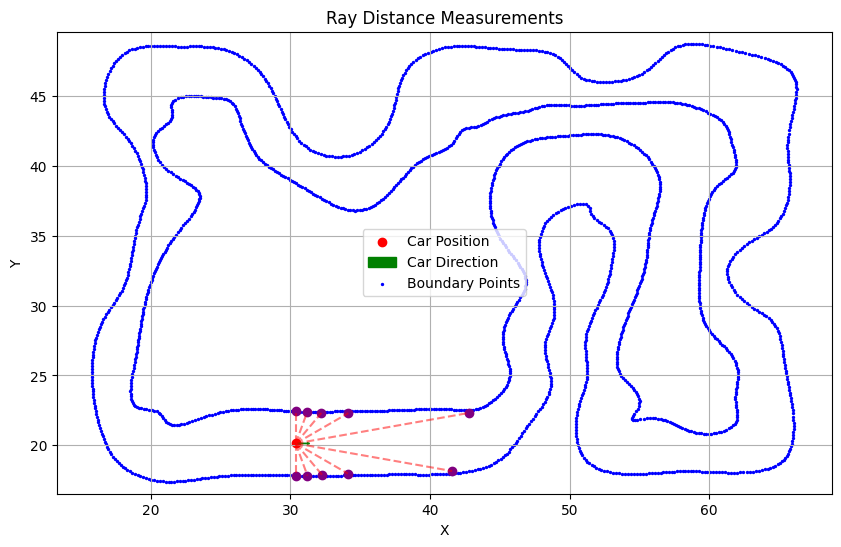

In [89]:
distances, hit_points = calculate_distances_to_boundary(car_pos, car_orientation, edge_points, num_rays, max_distance)

plt.figure(figsize=(10, 6))

# plot car position and orientation
plt.scatter(*car_pos, color='red', label='Car Position')
car_direction = jnp.array([jnp.cos(car_orientation), jnp.sin(car_orientation)]) 
plt.arrow(car_pos[0], car_pos[1], car_direction[0], car_direction[1], 
          color='green', head_width=0.1, length_includes_head=True, label='Car Direction')

# plot track boundary points
plt.scatter(edge_points[:, 0], edge_points[:, 1], color='blue', label='Boundary Points', s=2)

# plot hit points and rays
for i in range(num_rays):
    plt.plot([car_pos[0], hit_points[i, 0]], [car_pos[1], hit_points[i, 1]], 
             'r--', alpha=0.5)
    plt.scatter(hit_points[i, 0], hit_points[i, 1], color='purple')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ray Distance Measurements')
plt.grid(True)
plt.axis('equal')
plt.show()